# Model Developement: KNN for Activity Recognition


## Sample Extraction
* Notebook to generate "neighbors" for the KNN algorithm from recorded labeled training data.

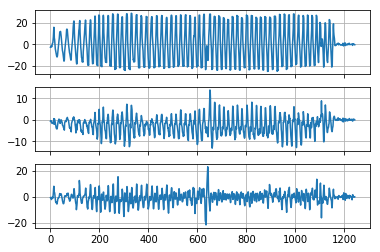

In [34]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import fftpack, signal
import pandas as pd

filename_raw = 'wavingLinAcc.txt'
filename_samples = 'samplesWaving.pkl'
label = 'waving'

# load measurement data
with open(filename_raw, newline='\n') as dataFile:
    data = pd.read_csv(dataFile, ';')
    x = data.get_values()[:, 0]
    y = data.get_values()[:, 1]
    z = data.get_values()[:, 2]

# have a look at the data
plt.figure(figsize=(20, 20))
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
ax1.plot(x)
ax1.grid()
ax2.plot(y)
ax2.grid()
ax3.plot(z)
ax3.grid()

# design/apply anti aliasing filter and downsample the signals
M = 3  # downsampling factor
lowpass = signal.firwin(numtaps=48, cutoff=1 / M, window=('chebwin', -50))

x = signal.convolve(x, lowpass, mode='same')
x = x[::M]

y = signal.convolve(y, lowpass, mode='same')
y = y[::M]

z = signal.convolve(z, lowpass, mode='same')
z = z[::M]


Now we split the input sequences into subsequences of 1s duration which equals approx. 17 samples on each axis.

In [35]:
# sampling frequency in Hz
fs = 50 / M;
numDftFeatures = 16;
NDFT = numDftFeatures * 2;

# generate
N = 16;  # window length
n = np.arange(0, N, 1)
window = signal.get_window('hann', N)

num_frames = int(len(x) / N)
features = np.zeros((num_frames, 3 * numDftFeatures))
for k in range(num_frames):
    for i, axis in zip(range(3), [x, y, z]):
        frame = axis[k * N:(k + 1) * N] * window
        DFT = fftpack.fft(frame, NDFT)  # compute DFT
        DFT = DFT[: np.int(NDFT / 2)]  # take only the onesided spectrum (for NDFT even!!!)
        DFT = np.abs(DFT) * 2 / np.sum(window)  # do normalization
        features[k, i * numDftFeatures:(i + 1) * numDftFeatures] = DFT

df = pd.DataFrame(features)
labels = pd.DataFrame({'label': num_frames*[label]})
df = pd.concat([df, labels], axis=1)
#print(df.head(5))

df.to_pickle(filename_samples)
